# Data report for the efficacy dataset for ASO gapmers

In [1]:
from oligogym.data import DatasetDownloader
from oligogym.stats import get_cosine_dist_to_nearest_neighbor, get_outliers
from oligogym.features import KMersCounts
from oligogym.models import LinearModel
from oligogym.metrics import regression_metrics

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Processed dataset

In [2]:
downloader = DatasetDownloader()
dataset = downloader.download("asoptimizer")
dataset.data.head()

,x,y,y_raw,targets,smiles,fasta,cell_line,concentration
0,RNA1{[cEt](G)[sp].[cEt](C)[sp].[cEt](T)[sp].d(...,33.0,33.0,KRAS,Cc1cn([C@H]2C[C@H](OP(=O)([S-])[O]C[C@H]3O[C@@...,GCTAAAACAAATGCTA,A431,2.0
1,RNA1{[cEt](T)[sp].[cEt](A)[sp].[cEt](T)[sp].d(...,7.0,7.0,KRAS,Cc1cn([C@H]2C[C@H](OP(=O)([S-])[O]C[C@]34O[C@@...,TATAATGGTGAATATC,A431,2.0
2,RNA1{[cEt](G)[sp].[cEt](C)[sp].[cEt](A)[sp].d(...,62.0,62.0,KRAS,Cc1cn([C@H]2C[C@H](OP(=O)([S-])[O]C[C@H]3O[C@@...,GCATGAAGATTTCTGG,A431,2.0
3,RNA1{[cEt](G)[sp].[cEt](G)[sp].[cEt](T)[sp].d(...,28.0,28.0,KRAS,Cc1cn([C@H]2C[C@H](OP(=O)([S-])[O]C[C@H]3O[C@@...,GGTGAATATCTTCAAA,A431,2.0
4,RNA1{[cEt](C)[sp].[cEt](A)[sp].[cEt](C)[sp].d(...,36.0,36.0,KRAS,Cc1cn([C@H]2C[C@H](OP(=O)([S-])[O]C[C@H]3O[C@@...,CACTTGTACTAGTATG,A431,2.0


## Features statistics

In [3]:
dataset.get_helm_stats()

,avg_nt_seq_len,combined_unique_monomers,avg_GC_content,avg_G_content,avg_C_content,avg_A_content,avg_TU_content,num_duplicates
0,16.779921,"[A, C, G, T, U, amino, cEt, d, lna, m, moe, mo...",43.216327,20.989968,32.721343,27.003002,29.780671,11853


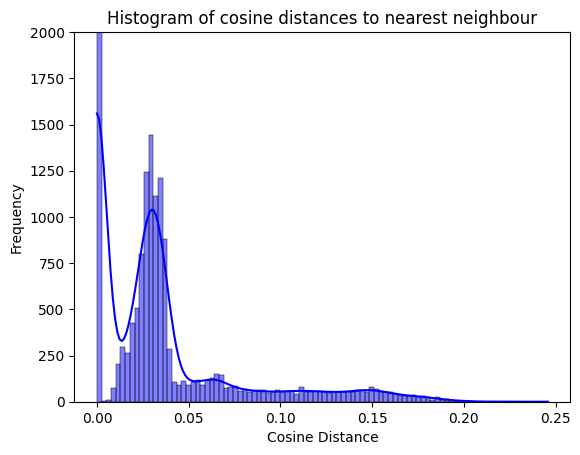

In [4]:
cosine_distances = get_cosine_dist_to_nearest_neighbor(np.unique(dataset.x))

fig, ax = plt.subplots()

sns.histplot(cosine_distances, ax=ax, color='blue', kde=True)

ax.set_title('Histogram of cosine distances to nearest neighbour')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')
ax.set_ylim([0,2000])

plt.show()

In [5]:
number_similar_sequences = np.sum(cosine_distances == 0)
print(f"{number_similar_sequences} ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count")

5387 ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count


## Labels statistics

In [6]:
print(dataset.get_label_stats().to_dict())

{'nobs': {0: 32602}, 'minmax': {0: (0.0, 100.0)}, 'mean': {0: 45.37804797193773}, 'variance': {0: 810.9479452601888}, 'skewness': {0: 0.04464719844991161}, 'kurtosis': {0: -1.0589660885330823}, 'num_zeros': {0: 2451}}


In [7]:
print(f"{len(get_outliers(dataset.y))} datapoints are identified as outliers by IQR method")

0 datapoints are identified as outliers by IQR method


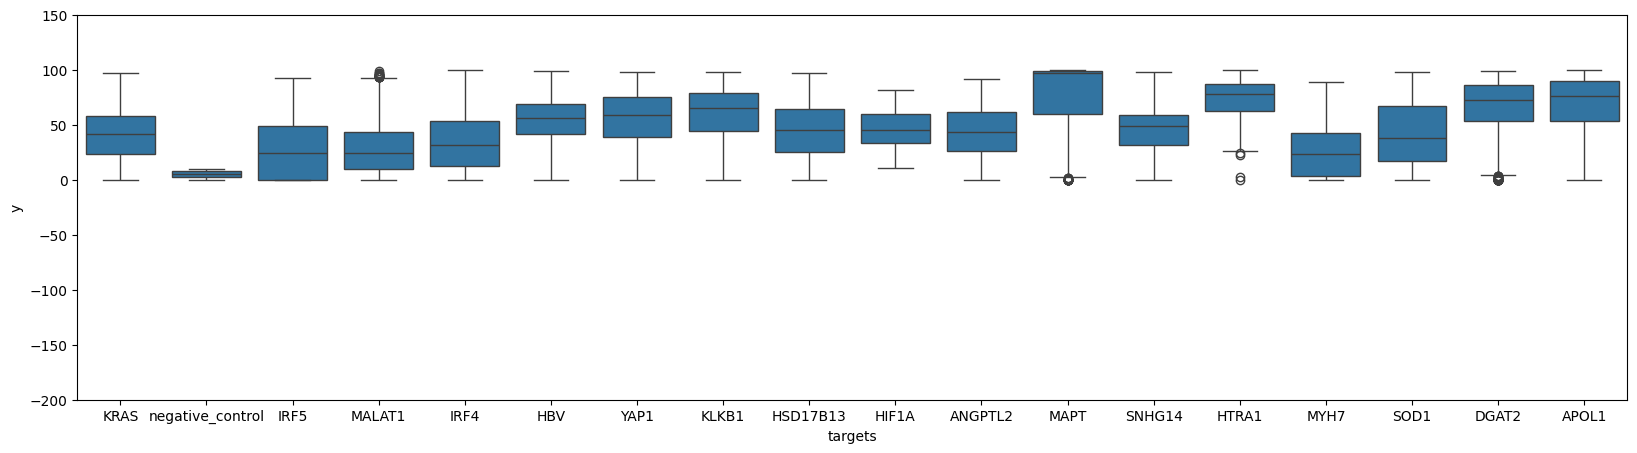

In [8]:
fig,ax=plt.subplots(figsize=[20,5])

sns.boxplot(data=dataset.data,x='targets',y='y')
ax.set_ylim([-200,150])
plt.show()

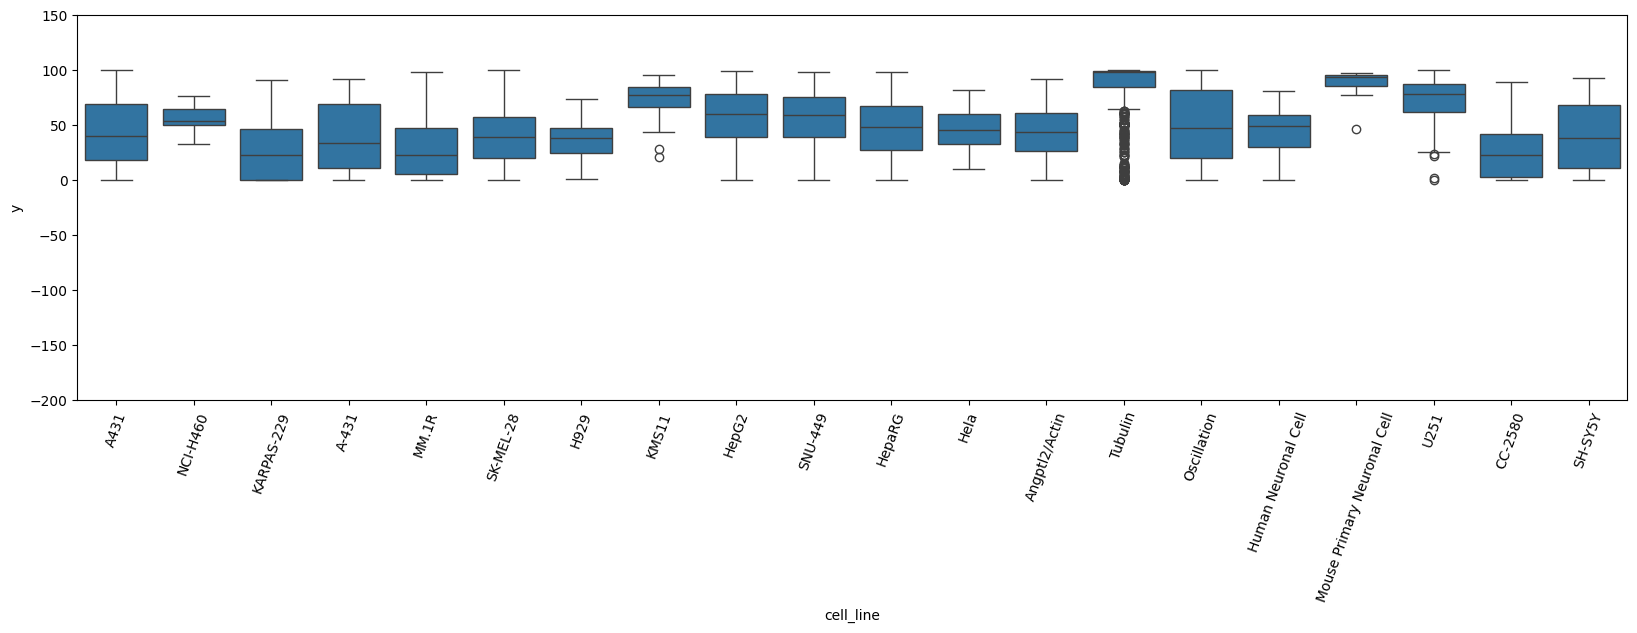

In [9]:
fig,ax=plt.subplots(figsize=[20,5])

sns.boxplot(data=dataset.data,x='cell_line',y='y')
ax.set_ylim([-200,150])
plt.xticks(rotation=70)
plt.show()

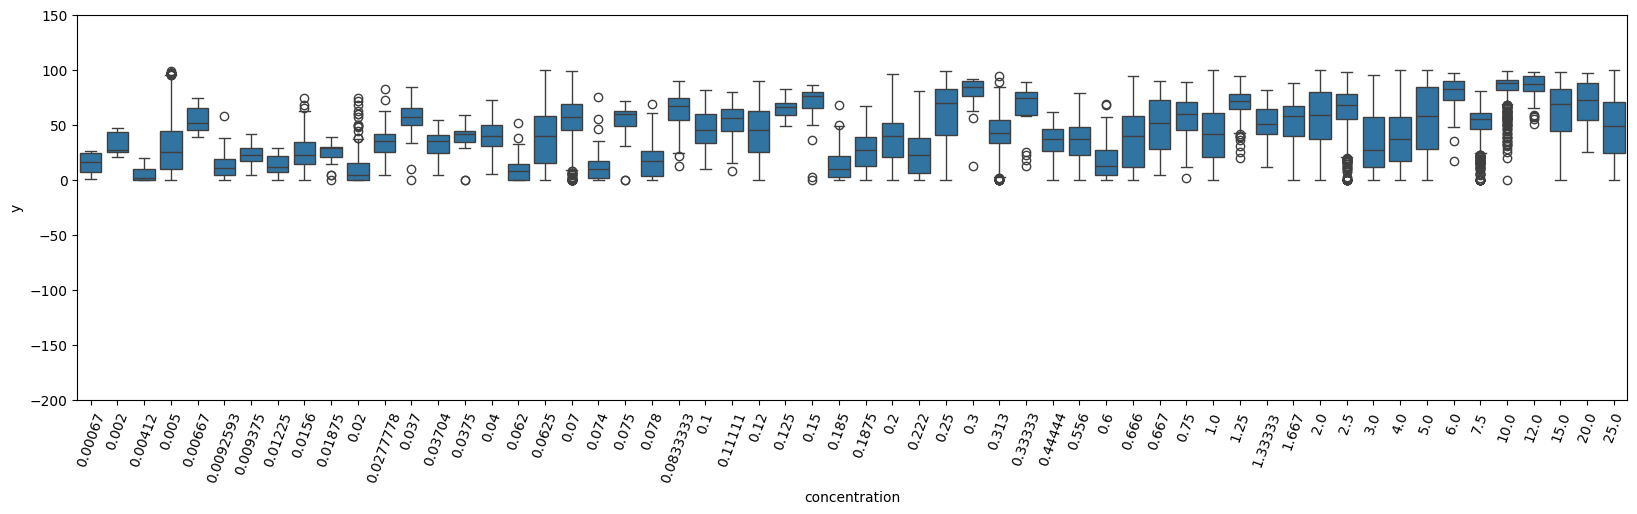

In [10]:
fig,ax=plt.subplots(figsize=[20,5])

sns.boxplot(data=dataset.data,x='concentration',y='y')
ax.set_ylim([-200,150])
plt.xticks(rotation=70)
plt.show()

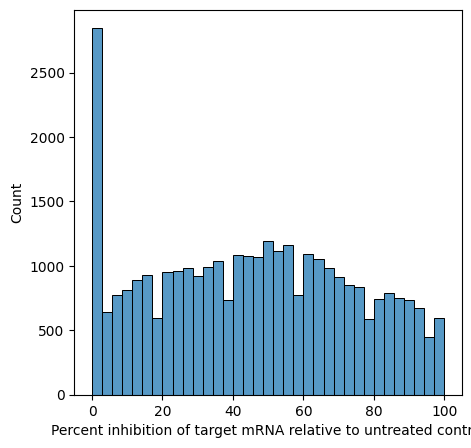

In [11]:
fig,ax=plt.subplots(figsize=[5,5])

sns.histplot(x=dataset.y)
ax.set_xlabel('Percent inhibition of target mRNA relative to untreated control')
plt.show()

## Splitting analysis

In [12]:
x_train, x_test, y_train, y_test, train_idx, test_idx = dataset.split(split_strategy='target',return_index=True, random_state=42)

In [13]:
print('Train targets:')
print(set(dataset.targets[train_idx]))
print(f"Size: {len(x_train)}")
print('Test targets:')
print(set(dataset.targets[test_idx]))
print(f"Size: {len(x_test)}")

Train targets:
{'MALAT1', 'HTRA1', 'KRAS', 'HIF1A', 'KLKB1', 'SNHG14', 'MYH7', 'SOD1', 'DGAT2', 'negative_control', 'YAP1', 'MAPT', 'IRF4', 'HBV'}
Size: 23313
Test targets:
{'APOL1', 'HSD17B13', 'IRF5', 'ANGPTL2'}
Size: 9289


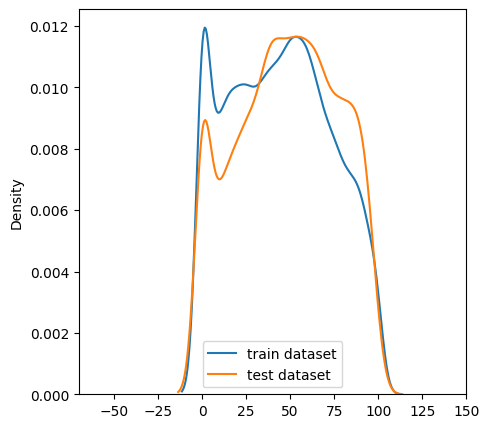

In [14]:
fig,ax=plt.subplots(figsize=[5,5])

sns.kdeplot(ax=ax, x=y_train, label='train dataset')
sns.kdeplot(ax=ax, x=y_test, label='test dataset')
ax.legend()
ax.set_xlim([-70,150])
plt.show()

## Predictability analysis

In [15]:
x_train,x_test,y_train,y_test = dataset.split('random', random_state=42)
feat=KMersCounts(k = [1,2,3], modification_abundance=True)
x_train=feat.fit_transform(x_train)
x_test=feat.transform(x_test)
model=LinearModel()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)

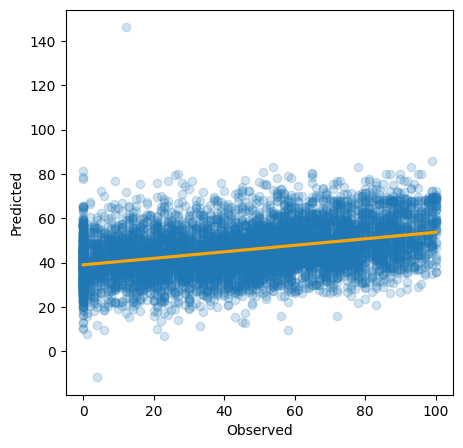

{'r2_score': 0.13778195870941823, 'root_mean_squared_error': 26.654553853921005, 'mean_absolute_error': 22.238330297479987, 'pearson_correlation': 0.3721685235390172, 'spearman_correlation': 0.36545102954959496}


In [16]:
fig, ax = plt.subplots(figsize=[5,5])
sns.regplot(ax=ax,x=y_test,y=y_pred,scatter_kws={'alpha':0.2},line_kws={'color':'orange'})
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
plt.show()
print(regression_metrics(y_test,y_pred))